# Imports

In [37]:
# Required imports
import google
from google.colab import auth
import ee
import folium
import requests
import io
from folium import plugins
import numpy as np

# geemap needs to be installed first in this colab environment
!pip install geemap
import geemap

# Authentication flow

In [38]:
# Standard authentication cell
auth.authenticate_user()
credentials, project_id = google.auth.default()
ee.Initialize(credentials, project='semiotic-garden-395711')

In [39]:
# Testing the authentication worked:
print(ee.Image("NASA/NASADEM_HGT/001").get("title").getInfo())

NASADEM: NASA NASADEM Digital Elevation 30m


# Defining the add layer function

In [40]:
# Defining the required add.layer function, which is not native to folium
def add_ee_layer(self, ee_image_object, vis_params, name):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

# Add Earth Engine drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

# Selecting Dates + Coordinates of Data

In [41]:
# Defining start and end dates. Note the target dataset is annual, while the
# features are updated every 5-10 days

# Initial year of interest (inclusive). Picked because features only go to
# 2015 and start in june, the earliest january images for features is 2016.
i_date = '2016'

# Final year of interest (exclusive). Picked because target only goes to 2021.
# So we should have 6 matches in total between features and targets (whole globe)
f_date = '2022'

In [42]:
# specify these coordinates, then expand a 500 x 500m square around, somewhere in Amazon rainforest
point = ee.Geometry.Point([-60.5260, -3.8466])
square = point.buffer(250).bounds()

In [43]:
# Defining the clipping feature — this is required because filter by Bounds only
# limits the image collection to images that intersetc the Geometry defined, but
# does not actually cut out the Geometry from the images that intersect
def clip_img(img):
    return img.clip(square)

# Defining Features

Loading our features dataset from: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_HARMONIZED#bands


In [44]:
# Initialize an empty list to hold the images
image_list = []

# Loop over each year from 2016 to 2021
for year in range(int(i_date), int(f_date)):
    start_date = ee.Date(f'{year}-01-01')
    end_date = start_date.advance(180, 'day') # Threshold 180 days to find an appropriate match to filter conditions

    filtered_images = (ee.ImageCollection("COPERNICUS/S2_HARMONIZED")
                      .filterDate(start_date, end_date) # applying the date range
                      .filterBounds(square) # applying the bounds of the coordinates
                      .filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 50) # applying cloud filter on image property
                      .sort('system:time_start')) # sorting collected images by system time

    clipped_images = filtered_images.map(clip_img) # clipping to the bounds. necessary as filtering by bounds does not clip!
    first_image = clipped_images.first() # getting the individual image, so that it can be bundled in an ImageCollection later

    if first_image:
        image_list.append(first_image)

features = ee.ImageCollection.fromImages(image_list) # create the ImageCollection


In [45]:
# Get info about the resulting collection - how many images are in the collection? Should return 6
features.size()

# Visualizing Features

In [46]:
# Getting first image from features to check
first_image_feature = ee.Image(features.first())

In [47]:
# Image chunk as a NumPy structured array.
url_features = first_image_feature.getDownloadUrl({
    'bands': "B8", # B8 is the NIR (near infra red) band
    'region': square,
    'scale': 10, # Scale of most of our feature bands is 10m, if it were different, would need to change here
    'format': 'NPY'
})
first_image_feature_array = requests.get(url_features)
first_image_feature_array = np.load(io.BytesIO(first_image_feature_array.content))
print(first_image_feature_array)

[[(   0,) (   0,) (   0,) ... (   0,) (   0,) (   0,)]
 [(4797,) (4871,) (4735,) ... (1173,) (1178,) (1085,)]
 [(4822,) (4914,) (4828,) ... (1061,) (1045,) (1039,)]
 ...
 [( 948,) ( 915,) ( 872,) ... (1771,) (1820,) (1757,)]
 [( 784,) ( 884,) ( 912,) ... (1713,) (1739,) (1689,)]
 [( 818,) ( 832,) ( 871,) ... (1841,) (1790,) (1642,)]]


In [48]:
np.max(first_image_feature_array["B8"]) # highest integer value. important for 'max' value in visualization later

4921

In [49]:
first_image_feature_array.shape # notice the shape! 50 x 50 of 10m pixels means we've selected a 500m x 500m square!
# not sure where the rogue 1 came from...

(51, 51)

In [50]:
# Displaying the data
Map_feature = geemap.Map() # important to initialise the Map object first, then edit it after. Different order does not work
Map_feature.centerObject(square, 15)
Map_feature.addLayer(first_image_feature, {"bands": "B8", "max": 10000}) # Max setting is for visualisation only. might need to tweak, otherwise see nothing!
Map_feature

Map(center=[-3.8465995686426444, -60.52599645096159], controls=(WidgetControl(options=['position', 'transparen…

# Get full depth Features nd array

## RGB + NIR bands together

In [51]:
# Get feature bands. Because they have different resolutions we'll stick just
# to those that have resolution of 10m. If we include ones that have 20m or
# 60m resolution, then we'd have to add padding or similar to the nd array in
# its depth. B2 is blue, B3 is green, B4 is red, B8 is NIR (near infra red)
feature_bands = ["B2", "B3", "B4", "B8"]

In [52]:
# Initialize an empty list to collect the numpy arrays
stacked_feature_list = []

# Loop through the image collection
for image in features.getInfo()['features']: # if you do .getInfo() on an image you get a dict, which we're accessing below
    image_id = image['id']
    ee_image = ee.Image(image_id)

    # Download the image as a NumPy array
    url = ee_image.getDownloadUrl({
        'bands': feature_bands,
        'region': square,
        'scale': 10,
        'format': 'NPY' # numpy
    })
    image_array = requests.get(url)
    image_array = np.load(io.BytesIO(image_array.content))

    # Append the numpy array to the list
    stacked_feature_list.append(image_array)

# Stack the arrays depth-wise
feature_stacked_array = np.stack(stacked_feature_list, axis=-1) # create a nd array where the depth dimension is time

In [53]:
feature_stacked_array.shape # depth dimension = 6 because one image for each of the 6 years

(51, 51, 6)

In [54]:
feature_stacked_array # hooray, the ndarray is not empty!

array([[[(4180, 4036, 4101, 4753), ( 845,  711,  463, 2186),
         (1185,  997,  706, 2391), (2553, 2309, 2224, 2761),
         ( 728,  608,  337, 2010), (1130,  972,  754, 1329)],
        [(4140, 3995, 4045, 4817), ( 843,  738,  458, 2213),
         (1015,  848,  560, 2258), (2595, 2343, 2236, 2797),
         ( 732,  620,  338, 2081), (1117,  991,  732, 1332)],
        [(4192, 3915, 3837, 4740), ( 865,  744,  492, 2348),
         ( 940,  791,  488, 2317), (2625, 2348, 2250, 2831),
         ( 726,  625,  332, 2080), (1159, 1003,  752, 1346)],
        ...,
        [( 858,  651,  388, 1278), (1604, 1496, 1223, 3005),
         ( 867,  723,  463, 2240), (2022, 1875, 1731, 2465),
         ( 759,  663,  387, 2242), (2267, 2003, 1871, 2511)],
        [( 831,  611,  368, 1221), (1575, 1392, 1101, 2905),
         ( 872,  755,  458, 2295), (1951, 1923, 1787, 2463),
         ( 756,  660,  383, 2259), (2415, 2135, 2003, 2616)],
        [( 829,  604,  361, 1165), (1448, 1275, 1025, 2992),
      

## NDVI band only

In [55]:
# Creating the NDVI array - NDVI is an index used for detecting forest in the academic literature
# Assuming data_array is your original array of shape (51, 51, 6) and dtype([('B2', 'f4'), ('B3', 'f4'), ('B4', 'f4'), ('B8', 'f4')])

# Extract B4 (Red) and B8 (NIR)
B4 = feature_stacked_array['B4']
B8 = feature_stacked_array['B8']

# Calculate NDVI - basically the normalised difference between Red and NIR bands
NDVI = (B8 - B4) / (B8 + B4 + 1e-10)  # adding a small constant to avoid division by zero

# Result will be a 3D ndarray of shape (51, 51, 6)

In [56]:
NDVI # again, hooray our nd array is not empty!

array([[[0.07363903, 0.65043413, 0.54407491, 0.10772317, 0.71282488,
         0.27604417],
        [0.08711352, 0.65705728, 0.602555  , 0.11146434, 0.72054568,
         0.29069767],
        [0.10528157, 0.65352113, 0.65204991, 0.11434757, 0.72470978,
         0.28312679],
        ...,
        [0.53421369, 0.42147588, 0.65741768, 0.1749285 , 0.70559148,
         0.14605203],
        [0.53681561, 0.45032451, 0.66727207, 0.15905882, 0.71006813,
         0.13271271],
        [0.52686763, 0.48966891, 0.7029703 , 0.16331836, 0.73768167,
         0.12081218]],

       [[0.08137962, 0.66260322, 0.59824369, 0.11784232, 0.67713004,
         0.28675799],
        [0.08340747, 0.67590028, 0.63609898, 0.11409943, 0.68962585,
         0.32362312],
        [0.08675694, 0.69097651, 0.67926456, 0.1177305 , 0.70622342,
         0.32317636],
        ...,
        [0.5184466 , 0.44941634, 0.65627266, 0.21222329, 0.70419772,
         0.1611641 ],
        [0.53886349, 0.46620622, 0.68403474, 0.19384185, 0.737

In [57]:
NDVI.shape # again, notice the shape. depth is time, 6 images for 6 years

(51, 51, 6)

# Defining Target

Loading our target dataset from: https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MCD12Q1#bands%5Blink

In [58]:
# Filtering down for the target band and the date range
target = (ee.ImageCollection("MODIS/061/MCD12Q1").filterDate(i_date, f_date)
          .filterBounds(square)
          .sort('system:time_start'))  # Sort by time to get earliest image

In [59]:
# Checking how many images are contained in the Image Collection, should return 6
target.size()

In [60]:
# Apply the clipping
target = target.map(clip_img)

# Visualizing the Target

In [61]:
# Getting first image from features to check
first_image_target = ee.Image(target.first())

In [62]:
# Image chunk as a NumPy structured array.
url_target = first_image_target.getDownloadUrl({
    'bands': "LC_Type1", # we're picking only one band, with up to 17 labels of different earth surface types (including forest)
    'region': square,
    'scale': 500, # notice the different scale! the resolution of target is 500m x 500m per pixel
    'format': 'NPY' # numpy
})
first_image_target_array = requests.get(url_target)
first_image_target_array = np.load(io.BytesIO(first_image_target_array.content))
print(first_image_target_array)

[[(2,) (2,)]
 [(2,) (2,)]]


Surpisingly it seems we have 4 pixels, rather than! 😮 ChatGPT suggests that this migth be to do with re-sampling of the data because we are not currently ensuring "snap-to-grid" of the pixel's borders when we select it. 🤷

In [63]:
first_image_target_array.shape

(2, 2)

In [64]:
# Create the palette for land cover categories (adjust as needed). This is only for visualisation!
landcover_palette = [
    '05450a', '086a10', '54a708', '78d203', '009900', 'c6b044', 'dcd159',
    'dade48', 'fbff13', 'b6ff05', '27ff87', 'c24f44', 'a5a5a5', 'ff6d4c',
    '69fff8', 'f9ffa4', '1c0dff'
]

In [65]:
# Displaying the data
Map_target = geemap.Map()
Map_target.centerObject(square, 15)
Map_target.addLayer(first_image_target, {"bands": "LC_Type1", "max": 20, "palette": landcover_palette}) # notice the different 'max' value, as this band has a lower range of values
Map_target

Map(center=[-3.8465995686426444, -60.52599645096159], controls=(WidgetControl(options=['position', 'transparen…

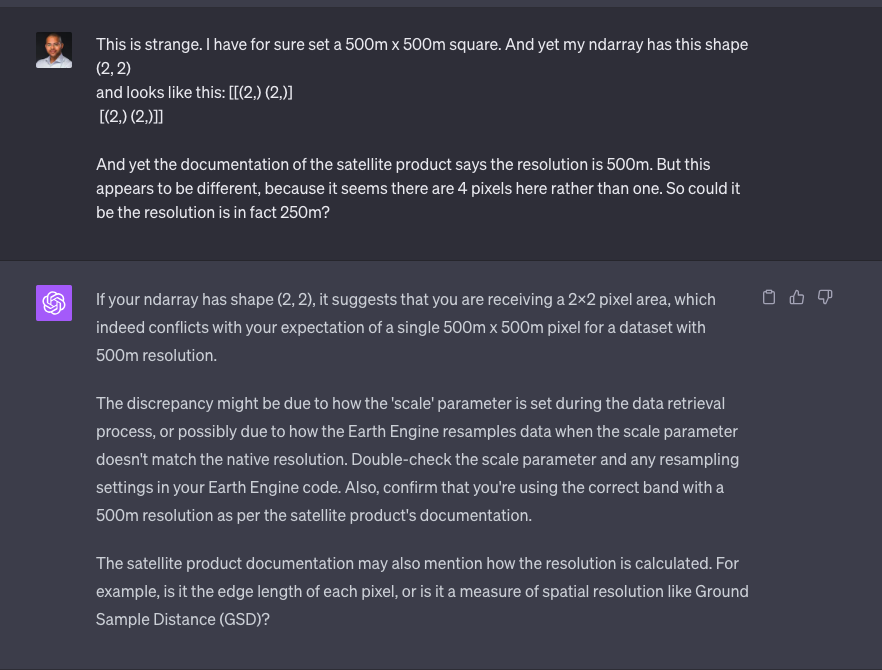

We had discussed as a team on how to approach the number of pixels in the Features vs the Target. Features have a resolution of 10m per pixel whereas the Target has a resolution of 500m per pixel, so we would expect each single Target pixel to have 50x50=2500 total matching Feature pixels.

This is also discussed in the Google approach, see image below. We initially wanted to take the middle approach of multiple feature pixels for one single Target pixel, but given that I can only get the Target data to return 4 pixels at a time, rather than simply one, we are jumping straight to the case of matching multiple feature pixels to multiple target pixels, I guesss. 🤷

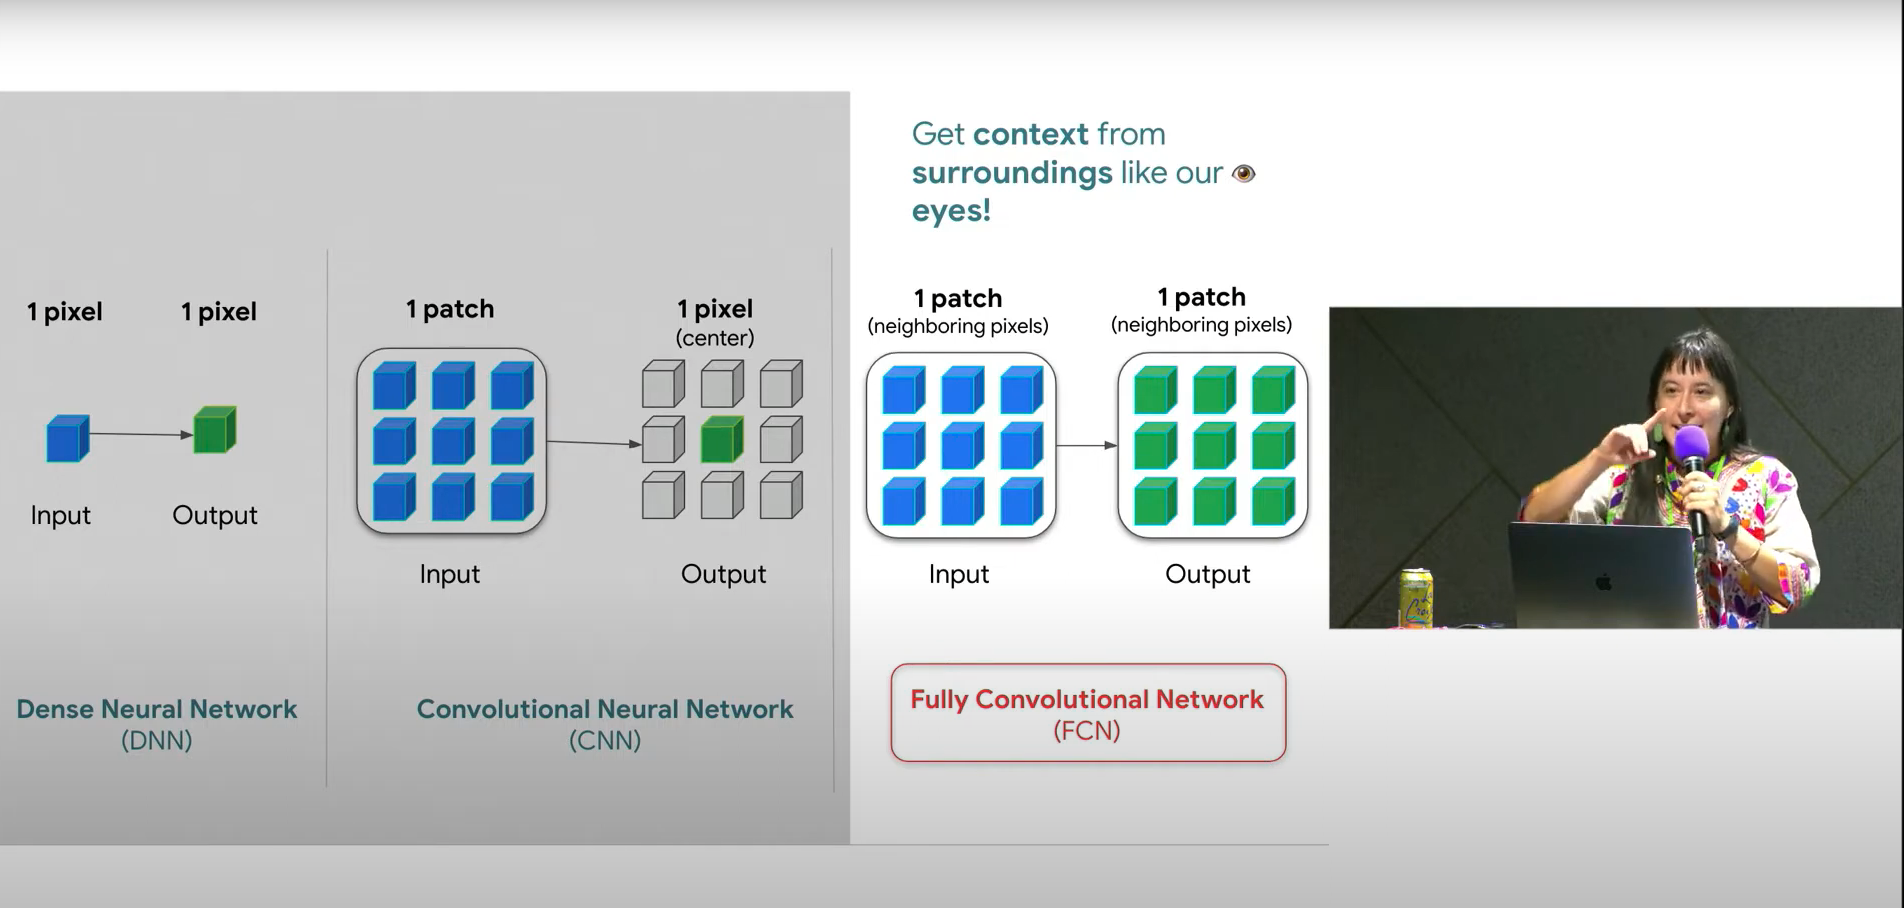

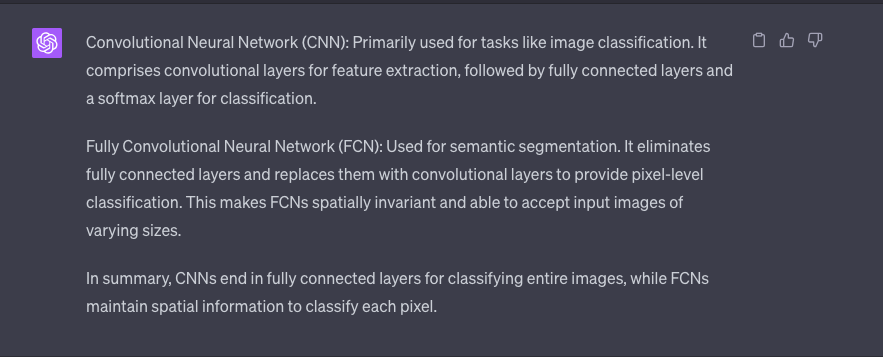

# Get full depth Target nd array

In [66]:
# Get the target bands. We are only picking one, though there's several to choose from
# We'll pick the LC_Type1 just because it's first
target_bands = ["LC_Type1"]

In [67]:
# Initialize an empty list to collect the numpy arrays
stacked_target_list = []

# Loop through the image collection
for image in target.getInfo()['features']:
    image_id = image['id']
    ee_image = ee.Image(image_id)

    # Download the image as a NumPy array
    url = ee_image.getDownloadUrl({
        'bands': target_bands,
        'region': square,
        'scale': 500, # again, notice the scale! 500m x 500m for a target pixel
        'format': 'NPY'
    })
    image_array = requests.get(url)
    image_array = np.load(io.BytesIO(image_array.content))

    # Append the numpy array to the list
    stacked_target_list.append(image_array)

# Stack the arrays depth-wise
target_stacked_array = np.stack(stacked_target_list, axis=-1)

In [68]:
target_stacked_array.shape

(2, 2, 6)

In [69]:
target_stacked_array

array([[[(2,), (2,), (2,), (2,), (2,), (2,)],
        [(2,), (2,), (2,), (2,), (2,), (2,)]],

       [[(2,), (2,), (2,), (2,), (2,), (2,)],
        [(2,), (2,), (2,), (2,), (2,), (2,)]]], dtype=[('LC_Type1', 'u1')])